Epoch  500  loss = 1.3857e-03
Epoch 1000  loss = 1.8029e-04
Epoch 1500  loss = 1.7270e-03
Epoch 2000  loss = 6.2602e-05


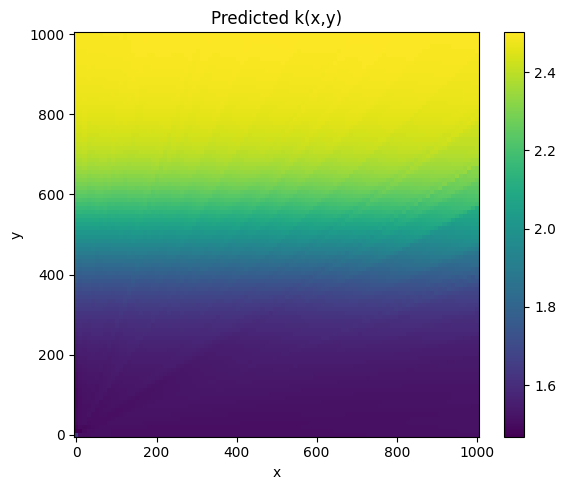

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import math
import torch
import torch.nn as nn
import torch.optim as optim

# Configuración de dispositivo
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

# Función k verdadera en 2D (solo depende de y)
def k_true_np(XY_np):
    y = XY_np[:, 1:2]
    epsilon = 100   # Steepness of the sigmoid
    y0 = 500        # Midpoint of the sigmoid
    k_true = 1.5 + 1.0 / (1 + np.exp(-(y - y0) / epsilon))
    return k_true

# 1) Generación de datos de entrenamiento
N_train = 10000
x_train = np.random.uniform(-10,1000, (N_train, 1))
y_train = np.random.uniform(-10, 1000, (N_train, 1))
XY_train = np.hstack([x_train, y_train])
k_train_np = k_true_np(XY_train)

XY_train_t = torch.tensor(XY_train, dtype=torch.float32, device=device)
k_train_t  = torch.tensor(k_train_np, dtype=torch.float32, device=device)

# 2) Definición de la red PINN_k_2D
class PINN_k_2D(nn.Module):
    def __init__(self, input_size=2, hidden_layers=12, hidden_units=128, act=nn.Tanh()):
        super().__init__()
        self.in_layer = nn.Linear(input_size, hidden_units)
        self.hidden   = nn.ModuleList([
            nn.Linear(hidden_units, hidden_units) 
            for _ in range(hidden_layers)
        ])
        self.act      = act
        self.out      = nn.Linear(hidden_units, 1)

    def forward(self, x):
        h = self.act(self.in_layer(x))
        for layer in self.hidden:
            h = self.act(layer(h))
        return self.out(h)

# 3) Instanciación y inicialización
model_k2d = PINN_k_2D().to(device)

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.0)

model_k2d.apply(init_weights)

# 4) Entrenamiento con Adam + MSE
optimizer = optim.Adam(model_k2d.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs = 2000
for epoch in range(1, epochs + 1):
    optimizer.zero_grad()
    k_pred = model_k2d(XY_train_t)
    loss = criterion(k_pred, k_train_t)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch:4d}  loss = {loss.item():.4e}")

# 5) Graficar predicciones en malla 2D
nx, ny = 100, 100
x_vals = np.linspace(0, 1000, nx)
y_vals = np.linspace(0, 1000, ny)
X_mesh, Y_mesh = np.meshgrid(x_vals, y_vals)
XY_mesh = np.vstack([X_mesh.ravel(), Y_mesh.ravel()]).T
XY_mesh_t = torch.tensor(XY_mesh, dtype=torch.float32, device=device)

with torch.no_grad():
    k_pred_mesh = model_k2d(XY_mesh_t).cpu().numpy().reshape(ny, nx)

fig, ax = plt.subplots(figsize=(6, 5))
c = ax.pcolormesh(X_mesh, Y_mesh, k_pred_mesh, shading='auto')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Predicted k(x,y)")
plt.colorbar(c, ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import torch
import torch.nn as nn
import matplotlib.colors as colors

# Configurar dispositivo CUDA
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

###############################################################################
# 1. Clases y funciones base
###############################################################################

class MLP_u(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_units, activation_function):
        super(MLP_u, self).__init__()
        self.linear_in = nn.Linear(input_size, hidden_units)
        self.linear_out = nn.Linear(hidden_units, output_size)
        self.layers = nn.ModuleList([nn.Linear(hidden_units, hidden_units) for _ in range(hidden_layers)])
        self.act = activation_function

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear_in(x)
        for layer in self.layers:
            x = self.act(layer(x))
        x = self.linear_out(x)
        return x
    
class MLP_k(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_units, activation_function):
        super(MLP_k, self).__init__()
        self.linear_in = nn.Linear(input_size, hidden_units)
        self.linear_out = nn.Linear(hidden_units, output_size)
        self.layers = nn.ModuleList([nn.Linear(hidden_units, hidden_units) for _ in range(hidden_layers)])
        self.act = activation_function

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear_in(x)
        for layer in self.layers:
            x = self.act(layer(x))
        x = self.linear_out(x)
        return x

def derivative(dy: torch.Tensor, x: torch.Tensor, order: int = 1) -> torch.Tensor:
    for _ in range(order):
        dy = torch.autograd.grad(
            dy, x,
            grad_outputs=torch.ones_like(dy),
            create_graph=True,
            retain_graph=True
        )[0]
    return dy

def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.0)

###############################################################################
# 2. Generar datos (observados y de colocalizaciÃ³n)
###############################################################################


def generate_interior_data(N_data=100):
    x_data = np.random.normal(loc=0.0, scale=3, size=(N_data, 1))
    y_data = np.random.uniform(low=-0.5, high=0,  size=(N_data, 1))
    X_data_np = np.hstack((x_data, y_data))
    # SoluciÃ³n analÃ­tica
    alpha = 0.5
    beta = 10
    epsilon = 0.2
    
    u_data_np = np.exp(-alpha * (x_data**2 + y_data**2)) * np.cos(beta * y_data)

    k_true = 1 + 2 / (1 + np.exp(-(y_data+1) / epsilon))
    X_data = torch.tensor(X_data_np, dtype=torch.float32, requires_grad=True, device=device)
    k_data = torch.tensor(k_true, dtype=torch.float32, requires_grad=True, device=device)
    u_data = torch.tensor(u_data_np, dtype=torch.float32, device=device)
    return X_data, u_data, k_data


def generate_collocation_points(N_interior=2000, N_boundary=200, std_dev=2.5):
    """
    Genera puntos de entrenamiento: interior (para el residual de la PDE)
    y frontera (para la condiciÃ³n de frontera u=0), en el dominio [-3,3]^2.

    Args:
        N_interior (int): NÃºmero de puntos interiores.
        N_boundary (int): NÃºmero de puntos en la frontera (y=0).

    Returns:
        (X_int, X_bnd) en formato (torch.Tensor, torch.Tensor).
    """
    # Puntos interiores en [-3,3]x[-3,3]
    x_int = np.random.normal(loc=0.0, scale=2.5, size=(N_interior, 1))
    y_int = -np.random.exponential(scale = 1.5,  size=(N_interior, 1))
    #y_int = np.clip(y_int, -100000, -0.01)  # fuerza a estar bajo el eje x

    X_int = np.hstack((x_int, y_int))  # (N_interior,2)
    X_int = torch.tensor(X_int, dtype=torch.float32, requires_grad=True)

    # Puntos sobre la lÃ­nea y = 0 (condiciÃ³n de frontera)
    x_bnd = np.random.normal(loc=0.0, scale=std_dev, size=(N_boundary, 1))
    y_bnd = np.zeros((N_boundary, 1))

    X_bnd = np.hstack((x_bnd, y_bnd))
    X_bnd = torch.tensor(X_bnd, dtype=torch.float32, requires_grad=True)
    
    return X_int, X_bnd

###############################################################################
# 3. DefiniciÃ³n de las pÃ©rdidas para el problema inverso
###############################################################################

def loss_pde_inverse(model_u, model_k, X_int, w):
    u = model_u(X_int)
    c = model_k(X_int)

    grads_u = derivative(u, X_int, order=1)
    u_x = grads_u[:, 0:1]
    u_y = grads_u[:, 1:2]

    u_xx = derivative(u_x, X_int, order=1)[:, 0:1]
    u_yy = derivative(u_y, X_int, order=1)[:, 1:2]

    x = X_int[:, 0:1]
    y = X_int[:, 1:2]
    
    sin = torch.sin
    exp = torch.exp
    cos = torch.cos
    alpha = 0.5
    beta = 10
    epsilon = 0.2
    forcing = (w**2*(exp(y/epsilon) + 1)**2*cos(beta*y) + (1 - exp(y/epsilon))**2*(4*alpha**2*x**2*cos(beta*y) + 4*alpha**2*y**2*cos(beta*y) + 4*alpha*beta*y*sin(beta*y) - 4*alpha*cos(beta*y) - beta**2*cos(beta*y)))*exp(-alpha*(x**2 + y**2))/(1 - exp(y/epsilon))**2

    residual = (u_xx+u_yy) + (w/c)**2 - forcing
    
    return torch.mean(residual**2)

def loss_bc(model, X_bnd, alpha=0.5, beta=10):
    x = X_bnd[:, 0:1]  # Solo la coordenada x, ya que y = 0
    u_true = torch.exp(-alpha * x**2)
    u_pred = model(X_bnd)

    return torch.mean((u_pred - u_true) ** 2)

def loss_data_u(model, X_data, u_data):
    u_pred = model(X_data)
    return torch.mean((u_pred - u_data)**2)

def loss_data_k(model, X_data, k_data):
    k_pred = model(X_data)
    return torch.mean((k_pred - k_data)**2)

###############################################################################
# 4. FunciÃ³n para graficar la soluciÃ³n y k
###############################################################################

def plot_solution_and_k(modelU, modelK, epoch, folder="figs_inverse_mixed", n_points=150):
    if not os.path.exists(folder):
        os.makedirs(folder)

    x_vals = np.linspace(-3, 3, n_points)
    y_vals = np.linspace(-3, 0, n_points)
    X_mesh, Y_mesh = np.meshgrid(x_vals, y_vals)
    XY_np = np.vstack([X_mesh.ravel(), Y_mesh.ravel()]).T
    XY_torch = torch.tensor(XY_np, dtype=torch.float32, device=device)

    with torch.no_grad():
        u_pred = modelU(XY_torch).cpu().numpy()
        k_pred = modelK(XY_torch).cpu().numpy()
    u_pred = u_pred.reshape(n_points, n_points)
    k_pred = k_pred.reshape(n_points, n_points)
    alpha = 0.5
    beta = 10
    epsilon = 0.2

    u_true = np.exp(-alpha * (X_mesh**2 + Y_mesh**2)) * np.cos(beta * Y_mesh)
    k_true = 1 + 2 / (1 + np.exp(-(Y_mesh+1) / epsilon))


    # Create a 2D figure with 4 subplots
    fig = plt.figure(figsize=(12, 10))
    
    vmin = u_pred.min()
    vmax = u_pred.max()
    norm1 = colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

    vmin = u_true.min()
    vmax = u_true.max()
    norm2 = colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
    
    # 2D plot for PINN u
    ax1 = fig.add_subplot(2, 2, 1)
    im1 = ax1.pcolormesh(X_mesh, Y_mesh, u_pred, cmap='seismic', shading='auto', norm=norm1)
    ax1.set_title(f"PINN u (epoch {epoch})")
    fig.colorbar(im1, ax=ax1)
    
    # 2D plot for Analytic u
    ax2 = fig.add_subplot(2, 2, 2)
    im2 = ax2.pcolormesh(X_mesh, Y_mesh, u_true, cmap='seismic', shading='auto', norm = norm2)
    ax2.set_title("Analytic u")
    fig.colorbar(im2, ax=ax2)
    
    # 2D plot for PINN k
    ax3 = fig.add_subplot(2, 2, 3)
    im3 = ax3.pcolormesh(
        X_mesh, Y_mesh, k_pred,
        cmap='GnBu', shading='auto'
    )
    ax3.set_title(f"PINN k (epoch {epoch})")
    cbar = fig.colorbar(im3, ax=ax3)
    
    # 2D plot for Analytic k
    ax4 = fig.add_subplot(2, 2, 4)
    im4 = ax4.pcolormesh(X_mesh, Y_mesh, k_true, cmap='GnBu', shading='auto')
    ax4.set_title("Analytic k")
    fig.colorbar(im4, ax=ax4)
    
    plt.tight_layout()
    plt.savefig(os.path.join(folder, f"solution_epoch_{epoch}.png"))
    plt.close(fig)

###############################################################################
# 5. Entrenamiento
###############################################################################

def train_inverse_pinn_mixed(
    modelU, modelK, w,
    X_int, X_bnd, 
    X_data, u_data, k_data,
    adam_epochs=10000,
    lbfgs_iterations=500,
    lr_adam=1e-4,
    lr_lbfgs=0.5,
    lambda_bc=5.0, 
    lambda_data=1.0,
    plot_every=1000
):
    # Lists to store losses
    adam_loss_history = []
    lbfgs_loss_history = []

    optimizer_adam = torch.optim.Adam(list(modelU.parameters()) + list(modelK.parameters()), lr=lr_adam)
    print(">>> FASE 1: Entrenamiento con Adam <<<")
    for epoch in tqdm(range(1, adam_epochs+1), desc="Adam"):
        optimizer_adam.zero_grad()

        pde_loss = loss_pde_inverse(modelU, modelK, X_int,w)
        data_loss_val_u = loss_data_u(modelU, X_data, u_data)
        data_loss_val_k = loss_data_k(modelK, X_data, k_data)
        bc_loss = loss_bc(modelU, X_data)

        total_loss = pde_loss + lambda_data * data_loss_val_u + lambda_data * data_loss_val_k + lambda_bc * bc_loss
        total_loss.backward()
        optimizer_adam.step()

        if epoch % plot_every == 0 or epoch == 1 or epoch == adam_epochs:
            adam_loss_history.append(total_loss.item())
            print(f"  [Adam epoch {epoch:5d}] total_loss={total_loss.item():.4e}, "
                  f"pde_loss={pde_loss.item():.4e}, "
                  f"data_loss={data_loss_val_u.item():.4e},"
                  f"data_loss_k={data_loss_val_k.item():.4e},"
                  f"loss_bc={bc_loss.item():.4e}")
            plot_solution_and_k(modelU, modelK, epoch, folder=f"exp1/figs_inverse_w={w}")

    print(">>> FASE 2: Entrenamiento con L-BFGS <<<")
    optimizer_lbfgs = torch.optim.LBFGS(
        list(modelU.parameters()) + list(modelK.parameters()),
        lr=lr_lbfgs,
        max_iter=lbfgs_iterations,
        history_size=100
    )

    iteration_lbfgs = [0]
    def closure():
        optimizer_lbfgs.zero_grad()
        pde_loss = loss_pde_inverse(modelU, modelK, X_int, w)
        data_loss_val_u = loss_data_u(modelU, X_data, u_data)
        data_loss_val_k = loss_data_k(modelK, X_data, k_data)
        bc_loss = loss_bc(modelU, X_data)

        total_loss = pde_loss + lambda_data * data_loss_val_u + lambda_data * data_loss_val_k + lambda_bc * bc_loss
        total_loss.backward()
        return total_loss

    for i in tqdm(range(1, lbfgs_iterations+1)):
        iteration_lbfgs[0] += 1
        current_pde = loss_pde_inverse(modelU, modelK, X_int, w).item()
        current_data_u = loss_data_u(modelU, X_data, u_data).item()
        current_data_k = loss_data_k(modelK, X_data, k_data).item()
        current_bc = loss_bc(modelU, X_data).item()
        current_total = current_pde + lambda_data * current_data_u + lambda_data * current_data_k + lambda_bc*current_bc
        if (i+1) % 50 == 0 or (i+1) == lbfgs_iterations:
            lbfgs_loss_history.append(current_total)
            print(f"  [LBFGS iter {i+1:5d}] total_loss={current_total:.4e}, "
                  f"pde_loss={current_pde:.4e}, "
                  f"data_loss_u={current_data_u:.4e},"
                  f"data_loss_k={current_data_k:.4e},"
                  f"data_loss_k={current_bc:.4e}")
            plot_solution_and_k(modelU, modelK, adam_epochs + i + 1, folder=f"exp1/figs_inverse_w={w}")

    return modelU, modelK, adam_loss_history, lbfgs_loss_history


###############################################################################
# 6. EjecuciÃ³n principal
###############################################################################

if __name__ == "__main__":
    set_seed(32)

    X_int, X_bnd = generate_collocation_points(N_interior=5000, N_boundary=500)
    X_data, u_data, k_data = generate_interior_data(N_data=5000)

    model_u = MLP_u(
        input_size=2,
        output_size=1,
        hidden_layers= 12,
        hidden_units=128,
        activation_function=nn.Tanh()
    ).to(device)
    model_u.apply(init_weights)

    model_k = MLP_k(
        input_size=2,
        output_size=1,
        hidden_layers= 12,
        hidden_units=128,
        activation_function=nn.Tanh()
    ).to(device)
    model_k.apply(init_weights)

    # 2) Copia la parte común (entrada + capas ocultas)
    model_k.linear_in.load_state_dict(model_k2d.in_layer.state_dict())
    for layer_uvk, layer_k2d in zip(model_k.layers, model_k2d.hidden):
        layer_uvk.load_state_dict(layer_k2d.state_dict())
    
    # 3) “Warm-start” del canal k en linear_out
    with torch.no_grad():
        # Copiando la fila 1 de los pesos (que sí es [H])
        model_k.linear_out.weight.data[0] = model_k2d.out.weight.data[0]
        # Copiando el bias escalar:
        model_k.linear_out.bias.data[0] = model_k2d.out.bias.data[0]

    plot_solution_and_k(model_u, model_k, 0, folder="figs_inverse")

    print(sum(p.numel() for p in model_u.parameters() if p.requires_grad) )

    w = 0.01
    while w < 1:
        model_u, model_k, adam_LOSS, LGFGS_LOSS = train_inverse_pinn_mixed(
            model_u, model_k, w,
            X_int, X_bnd,
            X_data, u_data, k_data,
            adam_epochs=1000,
            lbfgs_iterations=500,
            lr_adam=1e-4,
            lr_lbfgs=0.5,
            lambda_bc=1,
            lambda_data=100,
            plot_every=500
        )
        if w == 0.01:
            w = 0.05
        else:
            w += 0.05

    plot_solution_and_k(model_u, model_k, 0, folder="figs_inverse_mixed_final")

Usando dispositivo: cpu
198657
>>> FASE 1: Entrenamiento con Adam <<<


Adam:   0%|          | 0/1000 [00:00<?, ?it/s]

  [Adam epoch     1] total_loss=6.0691e+02, pde_loss=5.6999e+02, data_loss=1.3201e-01,data_loss_k=2.3516e-01,loss_bc=2.0406e-01


Adam:  50%|████▉     | 499/1000 [00:53<00:53,  9.40it/s]

  [Adam epoch   500] total_loss=1.3825e+01, pde_loss=1.3254e+01, data_loss=1.8586e-03,data_loss_k=1.7113e-05,loss_bc=3.8351e-01


Adam: 100%|█████████▉| 999/1000 [01:47<00:00,  8.54it/s]

  [Adam epoch  1000] total_loss=4.0184e+00, pde_loss=3.6027e+00, data_loss=2.6098e-04,data_loss_k=6.0911e-06,loss_bc=3.8896e-01


Adam: 100%|██████████| 1000/1000 [01:49<00:00,  9.16it/s]


>>> FASE 2: Entrenamiento con L-BFGS <<<


 10%|▉         | 48/500 [00:01<00:16, 27.36it/s]

  [LBFGS iter    50] total_loss=3.9011e+00, pde_loss=3.4704e+00, data_loss_u=4.7297e-04,data_loss_k=6.0790e-06,data_loss_k=3.8274e-01


 19%|█▉        | 96/500 [00:04<00:14, 27.17it/s]

  [LBFGS iter   100] total_loss=3.9011e+00, pde_loss=3.4704e+00, data_loss_u=4.7297e-04,data_loss_k=6.0790e-06,data_loss_k=3.8274e-01


 29%|██▉       | 147/500 [00:07<00:13, 26.73it/s]

  [LBFGS iter   150] total_loss=3.9011e+00, pde_loss=3.4704e+00, data_loss_u=4.7297e-04,data_loss_k=6.0790e-06,data_loss_k=3.8274e-01


 40%|███▉      | 198/500 [00:09<00:10, 27.57it/s]

  [LBFGS iter   200] total_loss=3.9011e+00, pde_loss=3.4704e+00, data_loss_u=4.7297e-04,data_loss_k=6.0790e-06,data_loss_k=3.8274e-01


 49%|████▉     | 246/500 [00:12<00:09, 27.30it/s]

  [LBFGS iter   250] total_loss=3.9011e+00, pde_loss=3.4704e+00, data_loss_u=4.7297e-04,data_loss_k=6.0790e-06,data_loss_k=3.8274e-01


 59%|█████▉    | 297/500 [00:14<00:07, 27.54it/s]

  [LBFGS iter   300] total_loss=3.9011e+00, pde_loss=3.4704e+00, data_loss_u=4.7297e-04,data_loss_k=6.0790e-06,data_loss_k=3.8274e-01


 70%|██████▉   | 348/500 [00:17<00:05, 27.57it/s]

  [LBFGS iter   350] total_loss=3.9011e+00, pde_loss=3.4704e+00, data_loss_u=4.7297e-04,data_loss_k=6.0790e-06,data_loss_k=3.8274e-01


 79%|███████▉  | 396/500 [00:20<00:03, 27.56it/s]

  [LBFGS iter   400] total_loss=3.9011e+00, pde_loss=3.4704e+00, data_loss_u=4.7297e-04,data_loss_k=6.0790e-06,data_loss_k=3.8274e-01


 89%|████████▉ | 447/500 [00:23<00:01, 27.18it/s]

  [LBFGS iter   450] total_loss=3.9011e+00, pde_loss=3.4704e+00, data_loss_u=4.7297e-04,data_loss_k=6.0790e-06,data_loss_k=3.8274e-01


100%|█████████▉| 498/500 [00:25<00:00, 27.32it/s]

  [LBFGS iter   500] total_loss=3.9011e+00, pde_loss=3.4704e+00, data_loss_u=4.7297e-04,data_loss_k=6.0790e-06,data_loss_k=3.8274e-01


100%|██████████| 500/500 [00:26<00:00, 18.81it/s]


>>> FASE 1: Entrenamiento con Adam <<<


Adam:   0%|          | 0/1000 [00:00<?, ?it/s]

  [Adam epoch     1] total_loss=9.9178e+00, pde_loss=9.4871e+00, data_loss=4.7297e-04,data_loss_k=6.0790e-06,loss_bc=3.8274e-01


Adam:  50%|████▉     | 499/1000 [00:53<00:52,  9.47it/s]

  [Adam epoch   500] total_loss=6.2602e+00, pde_loss=5.8447e+00, data_loss=2.5925e-04,data_loss_k=3.3856e-06,loss_bc=3.8925e-01


Adam: 100%|█████████▉| 999/1000 [01:47<00:00,  9.49it/s]

  [Adam epoch  1000] total_loss=4.4854e+00, pde_loss=4.0589e+00, data_loss=3.2377e-04,data_loss_k=3.2633e-07,loss_bc=3.9406e-01


Adam: 100%|██████████| 1000/1000 [01:48<00:00,  9.20it/s]


>>> FASE 2: Entrenamiento con L-BFGS <<<


 10%|▉         | 48/500 [00:01<00:16, 27.87it/s]

  [LBFGS iter    50] total_loss=4.4803e+00, pde_loss=4.0537e+00, data_loss_u=3.5155e-04,data_loss_k=3.2509e-07,data_loss_k=3.9138e-01


 19%|█▉        | 96/500 [00:04<00:14, 27.85it/s]

  [LBFGS iter   100] total_loss=4.4803e+00, pde_loss=4.0537e+00, data_loss_u=3.5155e-04,data_loss_k=3.2509e-07,data_loss_k=3.9138e-01


 29%|██▉       | 147/500 [00:06<00:12, 27.99it/s]

  [LBFGS iter   150] total_loss=4.4803e+00, pde_loss=4.0537e+00, data_loss_u=3.5155e-04,data_loss_k=3.2509e-07,data_loss_k=3.9138e-01


 40%|███▉      | 198/500 [00:09<00:11, 26.20it/s]

  [LBFGS iter   200] total_loss=4.4803e+00, pde_loss=4.0537e+00, data_loss_u=3.5155e-04,data_loss_k=3.2509e-07,data_loss_k=3.9138e-01


 49%|████▉     | 246/500 [00:12<00:09, 27.97it/s]

  [LBFGS iter   250] total_loss=4.4803e+00, pde_loss=4.0537e+00, data_loss_u=3.5155e-04,data_loss_k=3.2509e-07,data_loss_k=3.9138e-01


 59%|█████▉    | 297/500 [00:15<00:07, 28.04it/s]

  [LBFGS iter   300] total_loss=4.4803e+00, pde_loss=4.0537e+00, data_loss_u=3.5155e-04,data_loss_k=3.2509e-07,data_loss_k=3.9138e-01


 70%|██████▉   | 348/500 [00:17<00:05, 28.05it/s]

  [LBFGS iter   350] total_loss=4.4803e+00, pde_loss=4.0537e+00, data_loss_u=3.5155e-04,data_loss_k=3.2509e-07,data_loss_k=3.9138e-01


 79%|███████▉  | 396/500 [00:20<00:03, 27.81it/s]

  [LBFGS iter   400] total_loss=4.4803e+00, pde_loss=4.0537e+00, data_loss_u=3.5155e-04,data_loss_k=3.2509e-07,data_loss_k=3.9138e-01


 89%|████████▉ | 447/500 [00:22<00:01, 27.99it/s]

  [LBFGS iter   450] total_loss=4.4803e+00, pde_loss=4.0537e+00, data_loss_u=3.5155e-04,data_loss_k=3.2509e-07,data_loss_k=3.9138e-01


100%|█████████▉| 498/500 [00:25<00:00, 26.86it/s]

  [LBFGS iter   500] total_loss=4.4803e+00, pde_loss=4.0537e+00, data_loss_u=3.5155e-04,data_loss_k=3.2509e-07,data_loss_k=3.9138e-01


100%|██████████| 500/500 [00:26<00:00, 18.97it/s]


>>> FASE 1: Entrenamiento con Adam <<<


Adam:   0%|          | 0/1000 [00:00<?, ?it/s]

  [Adam epoch     1] total_loss=8.1287e+01, pde_loss=8.0860e+01, data_loss=3.5155e-04,data_loss_k=3.2509e-07,loss_bc=3.9138e-01


Adam:  50%|████▉     | 499/1000 [00:53<00:52,  9.59it/s]

  [Adam epoch   500] total_loss=5.9247e+01, pde_loss=5.8643e+01, data_loss=2.0442e-03,data_loss_k=5.1294e-07,loss_bc=3.9958e-01


Adam: 100%|█████████▉| 999/1000 [01:46<00:00,  9.52it/s]

  [Adam epoch  1000] total_loss=1.7610e+01, pde_loss=1.6851e+01, data_loss=3.5659e-03,data_loss_k=6.9320e-08,loss_bc=4.0271e-01


Adam: 100%|██████████| 1000/1000 [01:47<00:00,  9.28it/s]


>>> FASE 2: Entrenamiento con L-BFGS <<<


 10%|▉         | 48/500 [00:01<00:16, 27.18it/s]

  [LBFGS iter    50] total_loss=1.7335e+01, pde_loss=1.6574e+01, data_loss_u=3.5765e-03,data_loss_k=6.9274e-08,data_loss_k=4.0293e-01


 19%|█▉        | 96/500 [00:04<00:15, 26.72it/s]

  [LBFGS iter   100] total_loss=1.7335e+01, pde_loss=1.6574e+01, data_loss_u=3.5765e-03,data_loss_k=6.9274e-08,data_loss_k=4.0293e-01


 29%|██▉       | 147/500 [00:06<00:13, 27.03it/s]

  [LBFGS iter   150] total_loss=1.7335e+01, pde_loss=1.6574e+01, data_loss_u=3.5765e-03,data_loss_k=6.9274e-08,data_loss_k=4.0293e-01


 40%|███▉      | 198/500 [00:09<00:11, 26.92it/s]

  [LBFGS iter   200] total_loss=1.7335e+01, pde_loss=1.6574e+01, data_loss_u=3.5765e-03,data_loss_k=6.9274e-08,data_loss_k=4.0293e-01


 49%|████▉     | 246/500 [00:12<00:09, 26.65it/s]

  [LBFGS iter   250] total_loss=1.7335e+01, pde_loss=1.6574e+01, data_loss_u=3.5765e-03,data_loss_k=6.9274e-08,data_loss_k=4.0293e-01


 59%|█████▉    | 297/500 [00:15<00:07, 26.90it/s]

  [LBFGS iter   300] total_loss=1.7335e+01, pde_loss=1.6574e+01, data_loss_u=3.5765e-03,data_loss_k=6.9274e-08,data_loss_k=4.0293e-01


 70%|██████▉   | 348/500 [00:18<00:05, 27.23it/s]

  [LBFGS iter   350] total_loss=1.7335e+01, pde_loss=1.6574e+01, data_loss_u=3.5765e-03,data_loss_k=6.9274e-08,data_loss_k=4.0293e-01


 79%|███████▉  | 396/500 [00:20<00:03, 26.97it/s]

  [LBFGS iter   400] total_loss=1.7335e+01, pde_loss=1.6574e+01, data_loss_u=3.5765e-03,data_loss_k=6.9274e-08,data_loss_k=4.0293e-01


 89%|████████▉ | 447/500 [00:23<00:01, 27.02it/s]

  [LBFGS iter   450] total_loss=1.7335e+01, pde_loss=1.6574e+01, data_loss_u=3.5765e-03,data_loss_k=6.9274e-08,data_loss_k=4.0293e-01


100%|█████████▉| 498/500 [00:25<00:00, 27.02it/s]

  [LBFGS iter   500] total_loss=1.7335e+01, pde_loss=1.6574e+01, data_loss_u=3.5765e-03,data_loss_k=6.9274e-08,data_loss_k=4.0293e-01


100%|██████████| 500/500 [00:26<00:00, 18.64it/s]


>>> FASE 1: Entrenamiento con Adam <<<


Adam:   0%|          | 0/1000 [00:00<?, ?it/s]

  [Adam epoch     1] total_loss=2.0998e+02, pde_loss=2.0922e+02, data_loss=3.5765e-03,data_loss_k=6.9274e-08,loss_bc=4.0293e-01


Adam:  50%|████▉     | 499/1000 [00:53<00:52,  9.53it/s]

  [Adam epoch   500] total_loss=9.5842e+01, pde_loss=9.5020e+01, data_loss=4.3196e-03,data_loss_k=7.0589e-08,loss_bc=3.8935e-01


Adam: 100%|█████████▉| 999/1000 [01:46<00:00,  9.57it/s]

  [Adam epoch  1000] total_loss=9.1369e+00, pde_loss=8.6047e+00, data_loss=1.3619e-03,data_loss_k=8.7457e-08,loss_bc=3.9597e-01


Adam: 100%|██████████| 1000/1000 [01:47<00:00,  9.31it/s]


>>> FASE 2: Entrenamiento con L-BFGS <<<


 10%|▉         | 48/500 [00:01<00:16, 27.10it/s]

  [LBFGS iter    50] total_loss=7.7729e+00, pde_loss=7.2418e+00, data_loss_u=1.3532e-03,data_loss_k=8.7461e-08,data_loss_k=3.9574e-01


 19%|█▉        | 96/500 [00:04<00:14, 27.13it/s]

  [LBFGS iter   100] total_loss=7.7729e+00, pde_loss=7.2418e+00, data_loss_u=1.3532e-03,data_loss_k=8.7461e-08,data_loss_k=3.9574e-01


 29%|██▉       | 147/500 [00:06<00:13, 27.06it/s]

  [LBFGS iter   150] total_loss=7.7729e+00, pde_loss=7.2418e+00, data_loss_u=1.3532e-03,data_loss_k=8.7461e-08,data_loss_k=3.9574e-01


 40%|███▉      | 198/500 [00:09<00:11, 27.45it/s]

  [LBFGS iter   200] total_loss=7.7729e+00, pde_loss=7.2418e+00, data_loss_u=1.3532e-03,data_loss_k=8.7461e-08,data_loss_k=3.9574e-01


 49%|████▉     | 246/500 [00:12<00:09, 27.14it/s]

  [LBFGS iter   250] total_loss=7.7729e+00, pde_loss=7.2418e+00, data_loss_u=1.3532e-03,data_loss_k=8.7461e-08,data_loss_k=3.9574e-01


 59%|█████▉    | 297/500 [00:14<00:07, 27.21it/s]

  [LBFGS iter   300] total_loss=7.7729e+00, pde_loss=7.2418e+00, data_loss_u=1.3532e-03,data_loss_k=8.7461e-08,data_loss_k=3.9574e-01


 70%|██████▉   | 348/500 [00:17<00:05, 27.28it/s]

  [LBFGS iter   350] total_loss=7.7729e+00, pde_loss=7.2418e+00, data_loss_u=1.3532e-03,data_loss_k=8.7461e-08,data_loss_k=3.9574e-01


 79%|███████▉  | 396/500 [00:20<00:03, 26.97it/s]

  [LBFGS iter   400] total_loss=7.7729e+00, pde_loss=7.2418e+00, data_loss_u=1.3532e-03,data_loss_k=8.7461e-08,data_loss_k=3.9574e-01


 89%|████████▉ | 447/500 [00:23<00:01, 27.45it/s]

  [LBFGS iter   450] total_loss=7.7729e+00, pde_loss=7.2418e+00, data_loss_u=1.3532e-03,data_loss_k=8.7461e-08,data_loss_k=3.9574e-01


100%|█████████▉| 498/500 [00:25<00:00, 27.30it/s]

  [LBFGS iter   500] total_loss=7.7729e+00, pde_loss=7.2418e+00, data_loss_u=1.3532e-03,data_loss_k=8.7461e-08,data_loss_k=3.9574e-01


100%|██████████| 500/500 [00:26<00:00, 18.77it/s]


>>> FASE 1: Entrenamiento con Adam <<<


Adam:   0%|          | 0/1000 [00:00<?, ?it/s]

  [Adam epoch     1] total_loss=3.4213e+02, pde_loss=3.4160e+02, data_loss=1.3532e-03,data_loss_k=8.7461e-08,loss_bc=3.9574e-01


Adam:  50%|████▉     | 499/1000 [00:52<00:52,  9.59it/s]

  [Adam epoch   500] total_loss=1.0907e+02, pde_loss=1.0758e+02, data_loss=1.0948e-02,data_loss_k=2.5205e-07,loss_bc=3.9976e-01


Adam: 100%|█████████▉| 999/1000 [01:45<00:00,  9.57it/s]

  [Adam epoch  1000] total_loss=8.5738e+00, pde_loss=7.9022e+00, data_loss=2.8259e-03,data_loss_k=1.4270e-07,loss_bc=3.8900e-01


Adam: 100%|██████████| 1000/1000 [01:46<00:00,  9.36it/s]


>>> FASE 2: Entrenamiento con L-BFGS <<<


 10%|▉         | 48/500 [00:01<00:16, 27.15it/s]

  [LBFGS iter    50] total_loss=9.2246e+00, pde_loss=8.5532e+00, data_loss_u=2.8271e-03,data_loss_k=1.4270e-07,data_loss_k=3.8866e-01


 19%|█▉        | 96/500 [00:04<00:14, 27.01it/s]

  [LBFGS iter   100] total_loss=9.2246e+00, pde_loss=8.5532e+00, data_loss_u=2.8271e-03,data_loss_k=1.4270e-07,data_loss_k=3.8866e-01


 29%|██▉       | 147/500 [00:07<00:13, 27.08it/s]

  [LBFGS iter   150] total_loss=9.2246e+00, pde_loss=8.5532e+00, data_loss_u=2.8271e-03,data_loss_k=1.4270e-07,data_loss_k=3.8866e-01


 40%|███▉      | 198/500 [00:09<00:11, 27.31it/s]

  [LBFGS iter   200] total_loss=9.2246e+00, pde_loss=8.5532e+00, data_loss_u=2.8271e-03,data_loss_k=1.4270e-07,data_loss_k=3.8866e-01


 49%|████▉     | 246/500 [00:12<00:09, 26.98it/s]

  [LBFGS iter   250] total_loss=9.2246e+00, pde_loss=8.5532e+00, data_loss_u=2.8271e-03,data_loss_k=1.4270e-07,data_loss_k=3.8866e-01


 59%|█████▉    | 297/500 [00:14<00:07, 27.09it/s]

  [LBFGS iter   300] total_loss=9.2246e+00, pde_loss=8.5532e+00, data_loss_u=2.8271e-03,data_loss_k=1.4270e-07,data_loss_k=3.8866e-01


 70%|██████▉   | 348/500 [00:17<00:05, 27.08it/s]

  [LBFGS iter   350] total_loss=9.2246e+00, pde_loss=8.5532e+00, data_loss_u=2.8271e-03,data_loss_k=1.4270e-07,data_loss_k=3.8866e-01


 79%|███████▉  | 396/500 [00:20<00:03, 26.97it/s]

  [LBFGS iter   400] total_loss=9.2246e+00, pde_loss=8.5532e+00, data_loss_u=2.8271e-03,data_loss_k=1.4270e-07,data_loss_k=3.8866e-01


 89%|████████▉ | 447/500 [00:22<00:01, 27.15it/s]

  [LBFGS iter   450] total_loss=9.2246e+00, pde_loss=8.5532e+00, data_loss_u=2.8271e-03,data_loss_k=1.4270e-07,data_loss_k=3.8866e-01


100%|█████████▉| 498/500 [00:25<00:00, 27.09it/s]

  [LBFGS iter   500] total_loss=9.2246e+00, pde_loss=8.5532e+00, data_loss_u=2.8271e-03,data_loss_k=1.4270e-07,data_loss_k=3.8866e-01


100%|██████████| 500/500 [00:26<00:00, 18.86it/s]


>>> FASE 1: Entrenamiento con Adam <<<


Adam:   0%|          | 0/1000 [00:00<?, ?it/s]

  [Adam epoch     1] total_loss=5.0965e+02, pde_loss=5.0898e+02, data_loss=2.8271e-03,data_loss_k=1.4270e-07,loss_bc=3.8866e-01


Adam:  50%|████▉     | 499/1000 [00:53<00:52,  9.52it/s]

  [Adam epoch   500] total_loss=2.7602e+01, pde_loss=2.6580e+01, data_loss=6.1451e-03,data_loss_k=4.1845e-07,loss_bc=4.0732e-01


Adam: 100%|█████████▉| 999/1000 [01:46<00:00,  9.61it/s]

  [Adam epoch  1000] total_loss=2.6379e+01, pde_loss=2.5583e+01, data_loss=3.9747e-03,data_loss_k=3.8254e-07,loss_bc=3.9861e-01


Adam: 100%|██████████| 1000/1000 [01:47<00:00,  9.26it/s]


>>> FASE 2: Entrenamiento con L-BFGS <<<


 10%|▉         | 48/500 [00:01<00:16, 26.99it/s]

  [LBFGS iter    50] total_loss=2.9685e+01, pde_loss=2.8892e+01, data_loss_u=3.9520e-03,data_loss_k=3.8254e-07,data_loss_k=3.9683e-01


 19%|█▉        | 96/500 [00:04<00:14, 27.05it/s]

  [LBFGS iter   100] total_loss=2.9685e+01, pde_loss=2.8892e+01, data_loss_u=3.9520e-03,data_loss_k=3.8254e-07,data_loss_k=3.9683e-01


 29%|██▉       | 147/500 [00:07<00:13, 27.01it/s]

  [LBFGS iter   150] total_loss=2.9685e+01, pde_loss=2.8892e+01, data_loss_u=3.9520e-03,data_loss_k=3.8254e-07,data_loss_k=3.9683e-01


 40%|███▉      | 198/500 [00:09<00:11, 27.13it/s]

  [LBFGS iter   200] total_loss=2.9685e+01, pde_loss=2.8892e+01, data_loss_u=3.9520e-03,data_loss_k=3.8254e-07,data_loss_k=3.9683e-01


 49%|████▉     | 246/500 [00:12<00:09, 26.91it/s]

  [LBFGS iter   250] total_loss=2.9685e+01, pde_loss=2.8892e+01, data_loss_u=3.9520e-03,data_loss_k=3.8254e-07,data_loss_k=3.9683e-01


 59%|█████▉    | 297/500 [00:14<00:07, 27.12it/s]

  [LBFGS iter   300] total_loss=2.9685e+01, pde_loss=2.8892e+01, data_loss_u=3.9520e-03,data_loss_k=3.8254e-07,data_loss_k=3.9683e-01


 70%|██████▉   | 348/500 [00:17<00:05, 27.05it/s]

  [LBFGS iter   350] total_loss=2.9685e+01, pde_loss=2.8892e+01, data_loss_u=3.9520e-03,data_loss_k=3.8254e-07,data_loss_k=3.9683e-01


 79%|███████▉  | 396/500 [00:20<00:04, 26.00it/s]

  [LBFGS iter   400] total_loss=2.9685e+01, pde_loss=2.8892e+01, data_loss_u=3.9520e-03,data_loss_k=3.8254e-07,data_loss_k=3.9683e-01


 89%|████████▉ | 447/500 [00:22<00:02, 25.90it/s]

  [LBFGS iter   450] total_loss=2.9685e+01, pde_loss=2.8892e+01, data_loss_u=3.9520e-03,data_loss_k=3.8254e-07,data_loss_k=3.9683e-01


100%|█████████▉| 498/500 [00:25<00:00, 27.23it/s]

  [LBFGS iter   500] total_loss=2.9685e+01, pde_loss=2.8892e+01, data_loss_u=3.9520e-03,data_loss_k=3.8254e-07,data_loss_k=3.9683e-01


100%|██████████| 500/500 [00:26<00:00, 18.84it/s]


>>> FASE 1: Entrenamiento con Adam <<<


Adam:   0%|          | 0/1000 [00:00<?, ?it/s]

  [Adam epoch     1] total_loss=8.0450e+02, pde_loss=8.0370e+02, data_loss=3.9520e-03,data_loss_k=3.8254e-07,loss_bc=3.9683e-01


Adam:  50%|████▉     | 499/1000 [00:53<00:51,  9.67it/s]

  [Adam epoch   500] total_loss=4.0868e+01, pde_loss=3.9860e+01, data_loss=5.9814e-03,data_loss_k=6.6694e-07,loss_bc=4.1017e-01


Adam: 100%|█████████▉| 999/1000 [01:45<00:00,  9.61it/s]

  [Adam epoch  1000] total_loss=2.4294e+01, pde_loss=2.3469e+01, data_loss=4.1852e-03,data_loss_k=3.1235e-06,loss_bc=4.0553e-01


Adam: 100%|██████████| 1000/1000 [01:46<00:00,  9.36it/s]


>>> FASE 2: Entrenamiento con L-BFGS <<<


 10%|▉         | 48/500 [00:01<00:16, 27.21it/s]

  [LBFGS iter    50] total_loss=2.5038e+01, pde_loss=2.4216e+01, data_loss_u=4.1692e-03,data_loss_k=3.1865e-06,data_loss_k=4.0476e-01


 19%|█▉        | 96/500 [00:04<00:14, 27.20it/s]

  [LBFGS iter   100] total_loss=2.5038e+01, pde_loss=2.4216e+01, data_loss_u=4.1692e-03,data_loss_k=3.1865e-06,data_loss_k=4.0476e-01


 29%|██▉       | 147/500 [00:06<00:13, 26.53it/s]

  [LBFGS iter   150] total_loss=2.5038e+01, pde_loss=2.4216e+01, data_loss_u=4.1692e-03,data_loss_k=3.1865e-06,data_loss_k=4.0476e-01


 36%|███▌      | 180/500 [00:08<00:12, 25.89it/s]

In [ ]:
def relative_error_analytic(model_u, model_k, n_points=200, device='cpu'):
    """
    Computes the relative percentage error between model predictions and ground truth for u and k.
    
    Args:
        model_u (torch.nn.Module): Trained model predicting u(x, y).
        model_k (torch.nn.Module): Trained model predicting k(x, y).
        alpha (float): Parameter in the analytic solution of u.
        beta (float): Parameter in the analytic solution of u.
        epsilon (float): Parameter in the analytic solution of k.
        n_points (int): Number of grid points in each dimension.
        device (str): 'cpu' or 'cuda'.

    Returns:
        Tuple of relative percentage errors for u and k: (rel_error_u, rel_error_k)
    """
    alpha = 0.5
    beta = 10
    epsilon = 0.2
    # Crear la malla
    x = np.linspace(-3, 3, n_points)
    y = np.linspace(-3, 0, n_points)
    X, Y = np.meshgrid(x, y, indexing='ij')
    XY_np = np.stack([X.flatten(), Y.flatten()], axis=1)

    # Convertir a tensor para usar en los modelos
    XY_tensor = torch.tensor(XY_np, dtype=torch.float32, device=device)

    with torch.no_grad():
        u_pred = model_u(XY_tensor).cpu().numpy().reshape(n_points, n_points)
        k_pred = model_k(XY_tensor).cpu().numpy().reshape(n_points, n_points)

    # Soluciones analíticas
    u_true = np.exp(-alpha * (X**2 + Y**2)) * np.cos(beta * Y)
    k_true = 1 + 2 / (1 + np.exp(-(Y+1) / epsilon))

    # Evitar división por cero
    u_true_safe = np.where(np.abs(u_true) < 1e-8, 1e-8, u_true)
    k_true_safe = np.where(np.abs(k_true) < 1e-8, 1e-8, k_true)

    # Error relativo porcentual promedio
    rel_err_u = np.mean(np.abs((u_pred - u_true) / u_true_safe)) * 100
    rel_err_k = np.mean(np.abs((k_pred - k_true) / k_true_safe)) * 100

    return rel_err_u, rel_err_k



In [37]:
relative_error_analytic(model_u, model_k, n_points=200, device='cpu')

(75102.31989480945, 25.47353456360522)